#  Прогнозирование заказов такси

Цели работы:
Для компании-такси на основе предоставленных заказчиком данных сделать модель машинного обучения которая предсказывает количество заказов такси в следующий час. Значение метрики rmse не должно превышать 48

Этапы работы:
* [загрузить данные и выполнить ресемплирование по одному часу](#подготовка)
* [изучить данные](#анализ)
* [обучить модели с разными гиперпараметрами](#обучение)
* [проверить лучшую модель на тестовой выборкe (размер тестовой выборки 10% от общих данных)](#тестирование)
* [подготовить выводы](#выводы)


## Подготовка

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error as mse

from statsmodels.tsa.seasonal import seasonal_decompose
import natsort

In [2]:
warnings.filterwarnings('ignore')

In [3]:
RSTATE = 0

загрузим данные запарсив переведя столбец с датами в формат дат и сделав его индексами

In [4]:
df = pd.read_csv('C:\\Users\\Freo\\Desktop\\projects\\datasets\\p11.csv', parse_dates=['datetime'], index_col=['datetime'])

In [5]:
df

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


проверим что даты(индексы) в правильном хронологическом порядке

In [6]:
df.index.is_monotonic_increasing

True

ресемплируем данные по часу

In [7]:
df = df.resample('1H').sum()

In [8]:
df

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


## Анализ

посмотрим на графики

<Axes: xlabel='datetime'>

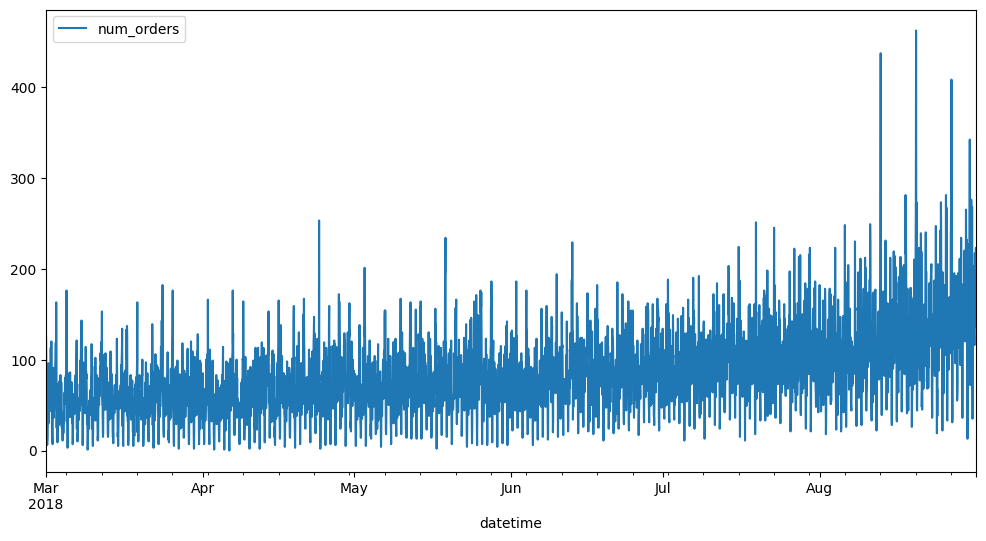

In [9]:
df.plot(figsize=(12,6))

количество заказов постепенно увеличивается; посмотрим какую информацию можно получить с помощью seasonal_decompose

In [10]:
decomposed = seasonal_decompose(df['num_orders'])

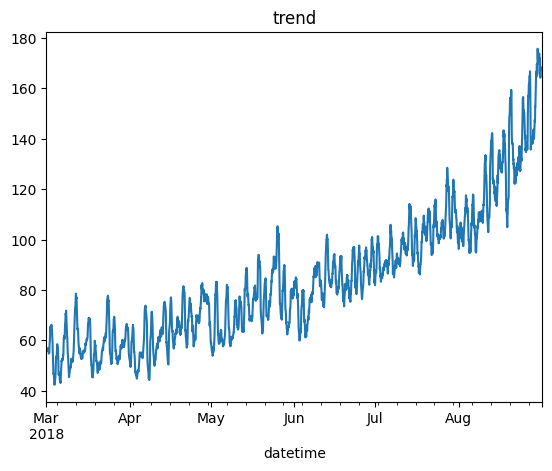

In [11]:
decomposed.trend.plot(ax=plt.gca())
plt.title('trend');

- общий восходящий тренд

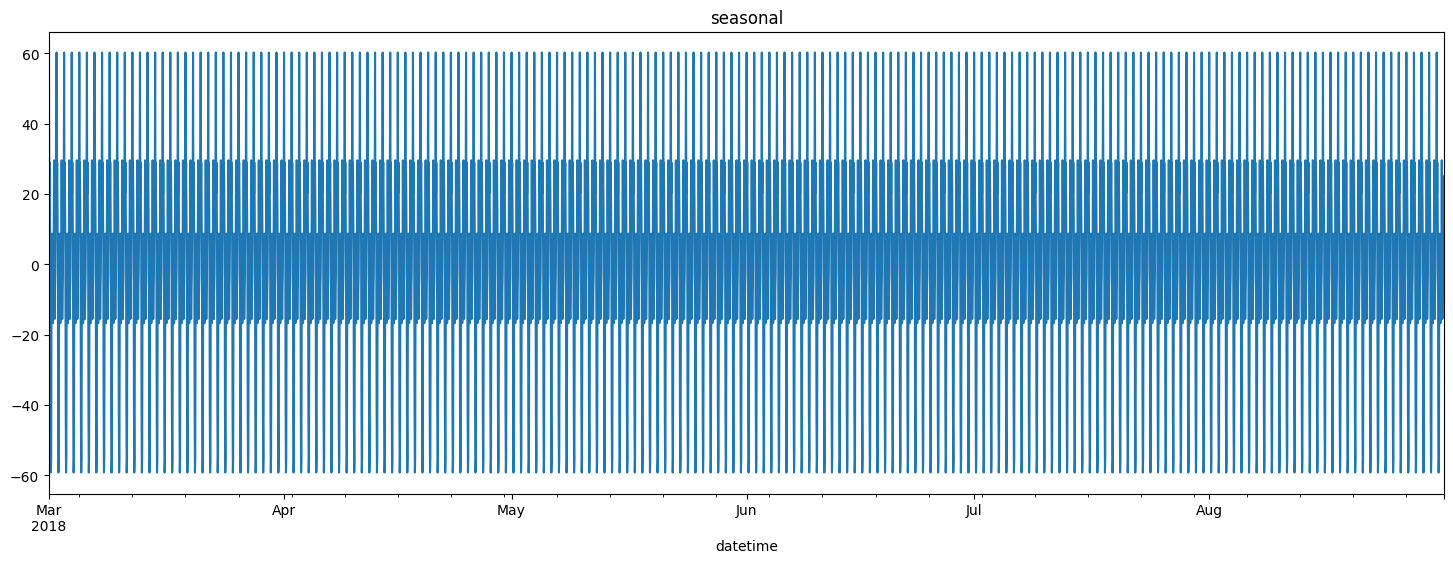

In [12]:
decomposed.seasonal.plot(figsize=(18,6), ax=plt.gca())
plt.title('seasonal');

заметна сильная "сезонность", скорее всего спрос сильно зависит от времени суток; посмотрим поближе вглубь месяца, недели и суток

<Axes: xlabel='datetime'>

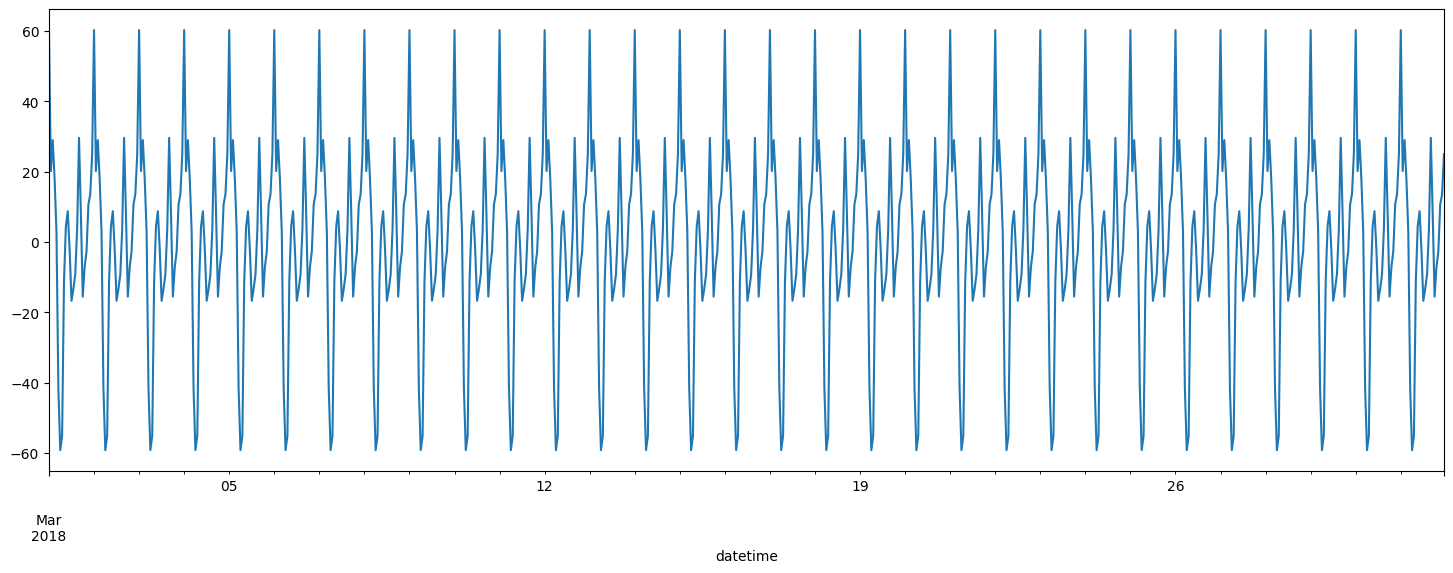

In [13]:
decomposed.seasonal['2018-03-01':'2018-03-31'].plot(figsize=(18,6))

<Axes: xlabel='datetime'>

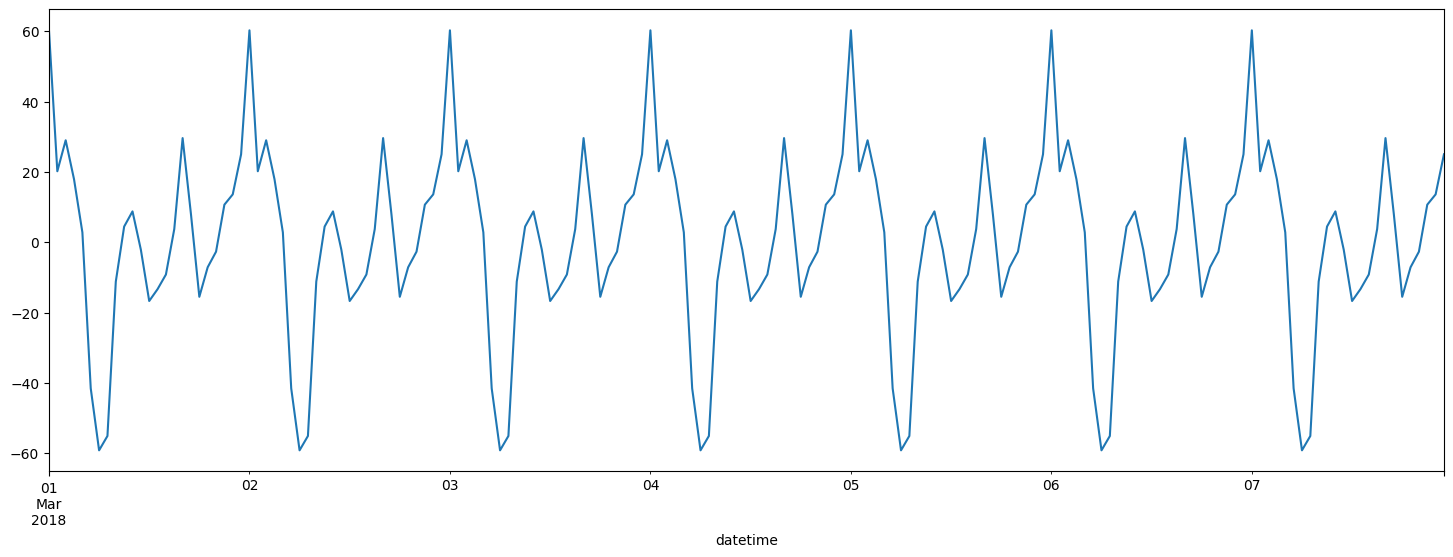

In [14]:
decomposed.seasonal['2018-03-01':'2018-03-07'].plot(figsize=(18,6))

<Axes: xlabel='datetime'>

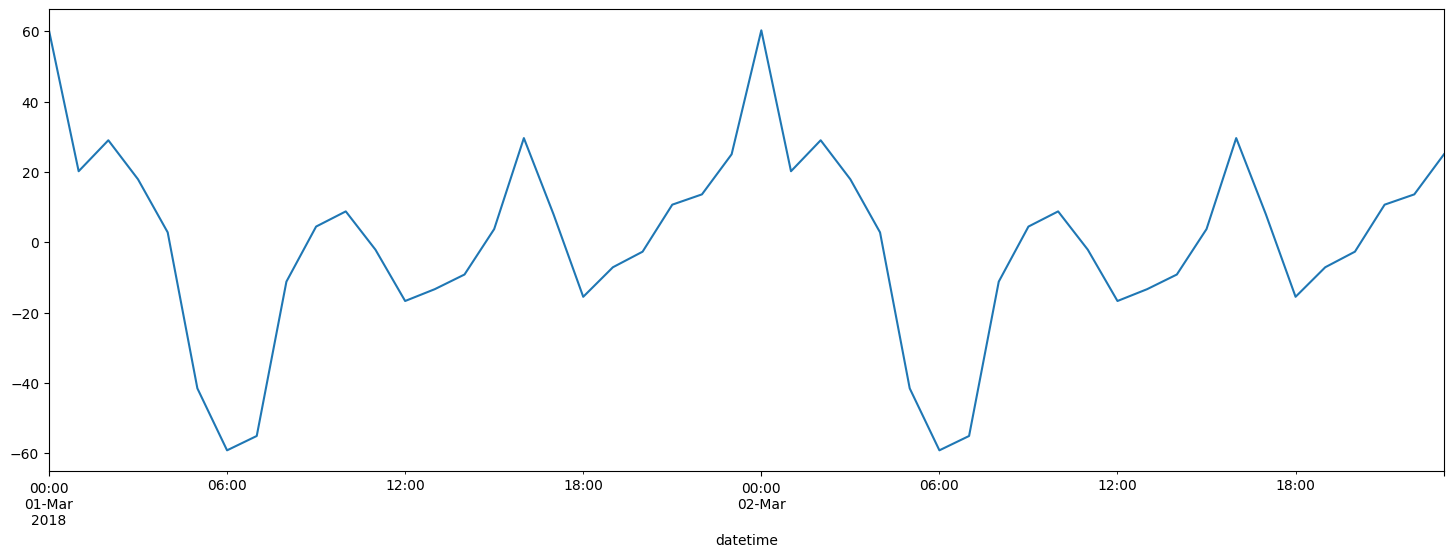

In [15]:
decomposed.seasonal['2018-03-01':'2018-03-02'].plot(figsize=(18,6),)

как и предлолагали спрос очень разнится по часам внутри дня; сильной разницы между днями визуально не заметно, но логичнее всего предположить о возможной недельной цикличности заказов; прогнозировать заказы на воскресенье лучше всего поможет прошлое воскресенье итд

создадим дополнительные фичи выделив дополнительные категориальные переменные на основе дат (№ часа в дне, № дня в неделе, № дня в месяце, № месяца в году) а так же сделав сдвиг до 168 часов (предполагая недельную цикличность)

In [16]:
def make_a_shift(df, lags):
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['day_of_week'] = df.index.dayofweek
    df['hour'] = df.index.hour
    
    for lag in range(1, lags+1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
    

In [17]:
make_a_shift(df,168)

удалим строки откуда брали значения сдвига, врятли их получится заполнить, и их не очень много

In [18]:
df

,num_orders,month,day,day_of_week,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_159,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,8,31,4,19,207.0,217.0,197.0,116.0,133.0,...,196.0,187.0,160.0,246.0,273.0,173.0,242.0,166.0,179.0,113.0
2018-08-31 20:00:00,154,8,31,4,20,136.0,207.0,217.0,197.0,116.0,...,118.0,196.0,187.0,160.0,246.0,273.0,173.0,242.0,166.0,179.0
2018-08-31 21:00:00,159,8,31,4,21,154.0,136.0,207.0,217.0,197.0,...,74.0,118.0,196.0,187.0,160.0,246.0,273.0,173.0,242.0,166.0


In [19]:
df = df.dropna()

## Обучение

In [20]:
x = df.drop(['num_orders'], axis=1)
y = df['num_orders']

In [21]:
x

,month,day,day_of_week,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_159,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-08 00:00:00,3,8,3,0,94.0,127.0,108.0,76.0,50.0,99.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0
2018-03-08 01:00:00,3,8,3,1,143.0,94.0,127.0,108.0,76.0,50.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0
2018-03-08 02:00:00,3,8,3,2,78.0,143.0,94.0,127.0,108.0,76.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0
2018-03-08 03:00:00,3,8,3,3,65.0,78.0,143.0,94.0,127.0,108.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0
2018-03-08 04:00:00,3,8,3,4,68.0,65.0,78.0,143.0,94.0,127.0,...,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,8,31,4,19,207.0,217.0,197.0,116.0,133.0,166.0,...,196.0,187.0,160.0,246.0,273.0,173.0,242.0,166.0,179.0,113.0
2018-08-31 20:00:00,8,31,4,20,136.0,207.0,217.0,197.0,116.0,133.0,...,118.0,196.0,187.0,160.0,246.0,273.0,173.0,242.0,166.0,179.0
2018-08-31 21:00:00,8,31,4,21,154.0,136.0,207.0,217.0,197.0,116.0,...,74.0,118.0,196.0,187.0,160.0,246.0,273.0,173.0,242.0,166.0


In [22]:
y

datetime
2018-03-08 00:00:00    143
2018-03-08 01:00:00     78
2018-03-08 02:00:00     65
2018-03-08 03:00:00     68
2018-03-08 04:00:00     60
                      ... 
2018-08-31 19:00:00    136
2018-08-31 20:00:00    154
2018-08-31 21:00:00    159
2018-08-31 22:00:00    223
2018-08-31 23:00:00    205
Freq: h, Name: num_orders, Length: 4248, dtype: int64

кросвалидация на случайных фолдах не будет иметь смысла, так как мы хотим сохранять порядок дней недели

In [23]:
x_temp, x_test, y_temp, y_test = train_test_split(x, y, shuffle=False, test_size=0.1)
x_train, x_valid, y_train, y_valid = train_test_split(x_temp, y_temp, shuffle=False, test_size=0.25)

In [24]:
x_train.shape

(2867, 172)

In [25]:
y_train.shape

(2867,)

In [26]:
x_valid.shape

(956, 172)

In [27]:
x_list=[x_train, x_valid, x_test]

In [28]:
cat_list = ['month','day','day_of_week','hour']


In [29]:
numlist = []
for el in x:
    if el not in cat_list:
        numlist.append(el)

In [30]:
numlist

['lag_1',
 'lag_2',
 'lag_3',
 'lag_4',
 'lag_5',
 'lag_6',
 'lag_7',
 'lag_8',
 'lag_9',
 'lag_10',
 'lag_11',
 'lag_12',
 'lag_13',
 'lag_14',
 'lag_15',
 'lag_16',
 'lag_17',
 'lag_18',
 'lag_19',
 'lag_20',
 'lag_21',
 'lag_22',
 'lag_23',
 'lag_24',
 'lag_25',
 'lag_26',
 'lag_27',
 'lag_28',
 'lag_29',
 'lag_30',
 'lag_31',
 'lag_32',
 'lag_33',
 'lag_34',
 'lag_35',
 'lag_36',
 'lag_37',
 'lag_38',
 'lag_39',
 'lag_40',
 'lag_41',
 'lag_42',
 'lag_43',
 'lag_44',
 'lag_45',
 'lag_46',
 'lag_47',
 'lag_48',
 'lag_49',
 'lag_50',
 'lag_51',
 'lag_52',
 'lag_53',
 'lag_54',
 'lag_55',
 'lag_56',
 'lag_57',
 'lag_58',
 'lag_59',
 'lag_60',
 'lag_61',
 'lag_62',
 'lag_63',
 'lag_64',
 'lag_65',
 'lag_66',
 'lag_67',
 'lag_68',
 'lag_69',
 'lag_70',
 'lag_71',
 'lag_72',
 'lag_73',
 'lag_74',
 'lag_75',
 'lag_76',
 'lag_77',
 'lag_78',
 'lag_79',
 'lag_80',
 'lag_81',
 'lag_82',
 'lag_83',
 'lag_84',
 'lag_85',
 'lag_86',
 'lag_87',
 'lag_88',
 'lag_89',
 'lag_90',
 'lag_91',
 'lag_92

In [31]:
scaler = StandardScaler()

In [32]:
scaler.fit(x_train[numlist])

StandardScaler()

In [33]:
for el in x_list:
    el[numlist] = scaler.transform(el[numlist])

In [34]:
for el in x_list:
    for cat in cat_list:
        el[cat] = el[cat].astype('category')

In [35]:
result_table = []

### lgbm

In [36]:
for i in range (2,16):
    model = LGBMRegressor(max_depth=i, learning_rate=0.5 )
    model.fit(x_train,y_train)
    pred_valid = model.predict(x_test)
    rmse = mse(y_test,pred_valid) ** 0.5
    print('dpt', i)
    print(rmse)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27560
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 172
[LightGBM] [Info] Start training from score 71.124869
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

In [37]:
for i in range(5, 51, 5):
    model = LGBMRegressor(max_depth=12, learning_rate=(i * 0.01) )
    model.fit(x_train,y_train)
    pred_valid = model.predict(x_test)
    rmse = mse(y_test,pred_valid) ** 0.5
    print('lr', (i * 0.01))
    print(rmse)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003900 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27560
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 172
[LightGBM] [Info] Start training from score 71.124869
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
lr 0.05
51.27478580180806
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leave

In [38]:
for i in range(3, 13, 1):
    model = LGBMRegressor(max_depth=12, learning_rate=(i * 0.01) )
    model.fit(x_train,y_train)
    pred_valid = model.predict(x_test)
    rmse = mse(y_test,pred_valid) ** 0.5
    print('lr', (i * 0.01))
    print(rmse)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27560
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 172
[LightGBM] [Info] Start training from score 71.124869
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
lr 0.03
53.113017268952184
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leav

In [39]:
row_for_result = []
row_for_result.append('lightGBM')
model = LGBMRegressor(max_depth=12, learning_rate=0.09)
model.fit(x_train,y_train)
pred_valid = model.predict(x_valid)
rmse = mse(y_valid,pred_valid, squared=False)
row_for_result.append(rmse)
print(rmse)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27560
[LightGBM] [Info] Number of data points in the train set: 2867, number of used features: 172
[LightGBM] [Info] Start training from score 71.124869
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

In [40]:
result_table.append(row_for_result)

### catboost

In [41]:
for i in range (2,15):
    model = CatBoostRegressor(loss_function="RMSE", iterations=200, depth=i)
    model.fit(x_train,y_train, cat_features=cat_list, verbose=25)
    pred_valid = model.predict(x_valid)
    rmse = mse(y_valid,pred_valid) ** 0.5
    print(i)
    print(rmse)

Learning rate set to 0.178943
0:	learn: 31.7626255	total: 147ms	remaining: 29.3s
25:	learn: 19.3520434	total: 392ms	remaining: 2.62s
50:	learn: 18.5113121	total: 659ms	remaining: 1.92s
75:	learn: 17.9982996	total: 912ms	remaining: 1.49s
100:	learn: 17.5423626	total: 1.17s	remaining: 1.15s
125:	learn: 17.1627198	total: 1.42s	remaining: 832ms
150:	learn: 16.8473007	total: 1.67s	remaining: 541ms
175:	learn: 16.5312853	total: 1.91s	remaining: 261ms
199:	learn: 16.2441858	total: 2.15s	remaining: 0us
2
27.938872381395583
Learning rate set to 0.178943
0:	learn: 31.3909353	total: 11.9ms	remaining: 2.36s
25:	learn: 18.8244575	total: 406ms	remaining: 2.72s
50:	learn: 18.0432877	total: 806ms	remaining: 2.35s
75:	learn: 17.3106550	total: 1.18s	remaining: 1.93s
100:	learn: 16.6209269	total: 1.56s	remaining: 1.53s
125:	learn: 16.1057948	total: 1.95s	remaining: 1.15s
150:	learn: 15.6196428	total: 2.35s	remaining: 761ms
175:	learn: 15.1327072	total: 2.76s	remaining: 377ms
199:	learn: 14.6822607	total:

In [42]:
for i in range (100,501,50):
    model = CatBoostRegressor(loss_function="RMSE", iterations=i, depth=3)
    model.fit(x_train,y_train, cat_features=cat_list, verbose=50)
    pred_valid = model.predict(x_valid)
    rmse = mse(y_valid,pred_valid) ** 0.5
    print(i)
    print(rmse)

Learning rate set to 0.314379
0:	learn: 29.7168943	total: 10.6ms	remaining: 1.05s
50:	learn: 17.0800433	total: 653ms	remaining: 627ms
99:	learn: 15.1096713	total: 1.29s	remaining: 0us
100
28.80775007434988
Learning rate set to 0.226095
0:	learn: 30.8066115	total: 10.7ms	remaining: 1.6s
50:	learn: 17.6787317	total: 672ms	remaining: 1.3s
100:	learn: 16.0314235	total: 1.31s	remaining: 636ms
149:	learn: 14.7809518	total: 1.95s	remaining: 0us
150
27.840205943457047
Learning rate set to 0.178943
0:	learn: 31.3909353	total: 11ms	remaining: 2.19s
50:	learn: 18.0432877	total: 803ms	remaining: 2.35s
100:	learn: 16.6209269	total: 1.52s	remaining: 1.49s
150:	learn: 15.6196428	total: 2.22s	remaining: 720ms
199:	learn: 14.6822607	total: 2.9s	remaining: 0us
200
27.500712637056296
Learning rate set to 0.149255
0:	learn: 31.7974018	total: 11.2ms	remaining: 2.78s
50:	learn: 18.1764378	total: 728ms	remaining: 2.84s
100:	learn: 16.9427128	total: 1.42s	remaining: 2.09s
150:	learn: 15.9863726	total: 2.11s	r

In [43]:
row_for_result = []
row_for_result.append('CatBoost')
model = CatBoostRegressor(loss_function="RMSE", iterations=250, depth=3)
model.fit(x_train,y_train, cat_features=cat_list, verbose=50)
pred_valid = model.predict(x_valid)
rmse = mse(y_valid,pred_valid, squared=False)
row_for_result.append(rmse)
print(rmse)

Learning rate set to 0.149255
0:	learn: 31.7974018	total: 11.6ms	remaining: 2.9s
50:	learn: 18.1764378	total: 706ms	remaining: 2.75s
100:	learn: 16.9427128	total: 1.42s	remaining: 2.09s
150:	learn: 15.9863726	total: 2.12s	remaining: 1.39s
200:	learn: 15.1247835	total: 2.85s	remaining: 696ms
249:	learn: 14.3962344	total: 3.53s	remaining: 0us
27.248998475145193


In [44]:
result_table.append(row_for_result)

### xgb

закодируем наши категориальные признаки

In [45]:
x_train_ohe = pd.get_dummies(x_train, columns=cat_list, drop_first = True)
x_valid_ohe = pd.get_dummies(x_valid, columns=cat_list, drop_first = True)
x_test_ohe = pd.get_dummies(x_test, columns=cat_list, drop_first = True)

In [46]:
x_train_ohe

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-08 00:00:00,0.673366,1.644185,1.084391,0.142393,-0.623516,0.818836,-0.682272,-0.740606,-0.592816,-0.827942,...,False,False,False,False,False,False,False,False,False,False
2018-03-08 01:00:00,2.115825,0.672992,1.643448,1.084189,0.142060,-0.623831,0.819230,-0.681699,-0.740118,-0.592268,...,False,False,False,False,False,False,False,False,False,False
2018-03-08 02:00:00,0.202359,2.115066,0.672454,1.643381,1.084308,0.141665,-0.623390,0.820418,-0.681197,-0.739564,...,False,False,False,False,False,False,False,False,False,False
2018-03-08 03:00:00,-0.180334,0.202110,2.114234,0.672153,1.643768,1.083815,0.142082,-0.622793,0.821286,-0.680646,...,False,False,False,False,False,False,False,False,False,False
2018-03-08 04:00:00,-0.092021,-0.180481,0.201668,2.114279,0.672075,1.643217,1.084200,0.142993,-0.622276,0.821777,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-07-05 06:00:00,-0.268648,0.525841,1.702297,1.319638,0.672075,2.526483,1.143083,0.938232,0.732905,0.556643,...,False,False,False,False,False,False,False,False,False,False
2018-07-05 07:00:00,-1.769983,-0.268772,0.525333,1.702243,1.319871,0.671625,2.526820,1.144405,0.939128,0.733399,...,False,False,False,False,False,False,False,False,False,False
2018-07-05 08:00:00,-1.181224,-1.769707,-0.269117,0.524997,1.702659,1.319353,0.672024,2.528709,1.145351,0.939614,...,False,False,False,False,False,False,False,False,False,False


проверим что размер выборок одинаков

In [47]:
x_train_ohe.shape[1] == x_valid_ohe.shape[1] == x_test_ohe.shape[1]

False

размер не одинаков, исправим выборки основываясь на тренировочной

In [48]:
del_from_valid = []
add_to_valid = []

In [49]:
for el in x_valid_ohe:
    if el not in x_train_ohe:
        del_from_valid.append(el)

In [50]:
del_from_valid

['month_8']

In [51]:
for el in x_train_ohe:
    if el not in x_valid_ohe:
        add_to_valid.append(el)

In [52]:
add_to_valid

['month_4', 'month_5', 'month_6', 'month_7']

In [53]:
x_valid_ohe = x_valid_ohe.drop(del_from_valid, axis=1)

In [54]:
for el in add_to_valid:
    x_valid_ohe[el] = 0

In [55]:
del_from_test = []
add_to_test = []

In [56]:
for el in x_test_ohe:
    if el not in x_train_ohe:
        del_from_test.append(el)

In [57]:
del_from_test

[]

In [58]:
for el in x_train_ohe:
    if el not in x_test_ohe:
        add_to_test.append(el)

In [59]:
add_to_test

['month_4',
 'month_5',
 'month_6',
 'month_7',
 'day_2',
 'day_3',
 'day_4',
 'day_5',
 'day_6',
 'day_7',
 'day_8',
 'day_9',
 'day_10',
 'day_11',
 'day_12',
 'day_13',
 'day_14']

In [60]:
for el in add_to_test:
    x_test_ohe[el] = 0

проверим

In [61]:
x_train_ohe.shape[1] == x_valid_ohe.shape[1] == x_test_ohe.shape[1]

True

Необходимо чтобы и порядок колонок совпадал, проверим и отсортируем их в одинаковом порядке

In [62]:
x_test_ohe.columns

Index(['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8',
       'lag_9', 'lag_10',
       ...
       'day_5', 'day_6', 'day_7', 'day_8', 'day_9', 'day_10', 'day_11',
       'day_12', 'day_13', 'day_14'],
      dtype='object', length=231)

In [63]:
row_for_result = []

In [64]:
x_train_ohe.columns == x_valid_ohe.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [65]:
col_names = x_train_ohe.columns
sorted_col_names = natsort.natsorted(col_names)

# re-order the columns
x_train_ohe = x_train_ohe[sorted_col_names]
x_valid_ohe = x_valid_ohe[sorted_col_names]
x_test_ohe = x_test_ohe[sorted_col_names]


обучим и подберем параметры xgb

In [66]:
for i in range(2,15):
    model = XGBRegressor(n_estimators = 100, learning_rate=0.5, max_depth=i, seed = RSTATE)
    model.fit(x_train_ohe,y_train)
    pred_valid = model.predict(x_valid_ohe)
    rmse = mse(y_valid,pred_valid) ** 0.5
    print(i)
    print(rmse)

2
29.562999414597257
3
31.13881415292243
4
31.050586252418363
5
31.59360168907868
6
31.836324001794374
7
32.078450260868465
8
32.50609219226131
9
33.366592443289086
10
32.6735759085263
11
31.87014266874206
12
31.863553001403076
13
31.318742146200652
14
32.32475846505361


In [67]:
for i in range (10, 200, 10):
    model = XGBRegressor(n_estimators = i, learning_rate=0.5, max_depth=2, seed = RSTATE)
    model.fit(x_train_ohe,y_train)
    pred_valid = model.predict(x_valid_ohe)
    rmse = mse(y_valid,pred_valid) ** 0.5
    print(i)
    print(rmse)

10
29.171255798485387
20
29.21570411808267
30
29.391615164652478
40
28.95456952744549
50
29.610989443458546
60
29.467194435222748
70
29.564944002448964
80
29.59573034109143
90
29.707127526094993
100
29.562999414597257
110
29.90444469505761
120
29.902001255499865
130
30.100337566072415
140
30.263834009368964
150
30.28260070245046
160
30.37706311928486
170
30.629194467804716
180
30.59856069369321
190
30.794920445881523


In [68]:
for i in range (20, 30, 1):
    model = XGBRegressor(n_estimators = i, learning_rate=0.5, max_depth=2, seed = RSTATE)
    model.fit(x_train_ohe,y_train)
    pred_valid = model.predict(x_valid_ohe)
    rmse = mse(y_valid,pred_valid) ** 0.5
    print(i)
    print(rmse)

20
29.21570411808267
21
29.291728705650655
22
29.35646761265004
23
29.351851595687467
24
29.346238501184033
25
29.41400526347181
26
29.481670532280802
27
29.42912606735813
28
29.36359429569769
29
29.465210995355285


In [69]:
for i in range (5, 50, 5):
    model = XGBRegressor(n_estimators = 25, learning_rate=(i*0.01), max_depth=2, seed = RSTATE)
    model.fit(x_train_ohe,y_train)
    pred_valid = model.predict(x_valid_ohe)
    rmse = mse(y_valid,pred_valid) ** 0.5
    print(i)
    print(rmse)

5
36.38623592240573
10
30.29776479790742
15
28.482643923113933
20
28.077645874584395
25
28.3762246961072
30
28.065215415505584
35
28.023183688700502
40
28.45752610970931
45
28.398925059479154


In [70]:
row_for_result = []
row_for_result.append('XGBR')
model = XGBRegressor(n_estimators = 25, learning_rate=0.3, max_depth=2, seed = RSTATE)
model.fit(x_train_ohe,y_train)
pred_valid = model.predict(x_valid_ohe)
rmse = mse(y_valid,pred_valid, squared=False)
row_for_result.append(rmse)
result_table.append(row_for_result)
print(rmse)

28.065215415505584


### DT

In [71]:
for i in range(2, 20):
    model = DecisionTreeRegressor (max_depth=i)
    model.fit(x_train_ohe,y_train)
    pred_valid = model.predict(x_valid_ohe)
    rmse = mse(y_valid,pred_valid) ** 0.5
    print(i)
    print(rmse)

2
35.59183590623577
3
32.64469789873327
4
30.934178532970726
5
32.77704856376134
6
32.786712900889896
7
34.2294639395591
8
35.34208546493177
9
36.51639560093147
10
37.59311830225165
11
37.551955334026836
12
36.99764643831442
13
37.86709466997578
14
39.15488091679582
15
37.805567989296044
16
38.93384579476769
17
37.82400018933399
18
36.91709304097396
19
38.242648158153


In [72]:
row_for_result = []
row_for_result.append('DecisionTree')
model = DecisionTreeRegressor (max_depth=4)
model.fit(x_train_ohe,y_train)
pred_valid = model.predict(x_valid_ohe)
rmse = mse(y_valid,pred_valid, squared=False)
row_for_result.append(rmse)
print(rmse)


30.934178532970726


In [73]:
result_table.append(row_for_result)

### RF

In [74]:
for i in range(2, 28):
    model = RandomForestRegressor(max_depth=i)
    model.fit(x_train_ohe,y_train)
    pred_valid = model.predict(x_valid_ohe)
    rmse = mse(y_valid,pred_valid) ** 0.5
    print(i)
    print(rmse)

2
34.79688844820116
3
31.229144550469265
4
29.795754343480812
5
29.12808234611013
6
28.73244413585376
7
28.403771066125387
8
28.417272913178554
9
28.265521240454234
10
28.182240806183774
11
27.982698968265733
12
28.415999442045266
13
28.264595911322566
14
28.444527421251593
15
28.488784277887362
16
28.22247999388327
17
28.06167820028344
18
28.2082515845441
19
28.269314948173648
20
28.16900790831081
21
28.25178778066174
22
28.290229755952268
23
28.228292584449882
24
28.254060016013533
25
28.0972275780623
26
28.191339373581243
27
28.24042966544985


In [75]:
for i in range(20, 200, 10):
    model = RandomForestRegressor(max_depth=19, n_estimators=i)
    model.fit(x_train_ohe,y_train)
    pred_valid = model.predict(x_valid_ohe)
    rmse = mse(y_valid,pred_valid) ** 0.5
    print(i)
    print(rmse)

20
29.013860227318908
30
28.724111332571294
40
28.409014194056454
50
28.348504467526535
60
27.926590405221702
70
28.190462652216443
80
28.516219640923296
90
28.401884608663195
100
28.07954811950359
110
28.313147449064402
120
27.997452680771705
130
28.225001002849844
140
28.238426242480017
150
28.41066824921164
160
28.296645431837526
170
28.070900024385637
180
28.16297529782825
190
28.26564559905108


In [76]:
row_for_result = []
row_for_result.append('Random Forest')
model = RandomForestRegressor(max_depth=19, n_estimators=80)
model.fit(x_train_ohe,y_train)
pred_valid = model.predict(x_valid_ohe)
rmse = mse(y_valid,pred_valid, squared=False)
row_for_result.append(rmse)
print(rmse)

28.292365507917882


In [77]:
result_table.append(row_for_result)

### linear 

In [78]:
row_for_result = []

In [79]:
row_for_result.append('Linear')

In [80]:
model = LinearRegression()

In [81]:
model.fit(x_train_ohe,y_train)

LinearRegression()

In [82]:
pred_valid = model.predict(x_valid_ohe)

In [83]:
rmse = mse(y_valid,pred_valid, squared=False)
row_for_result.append(rmse)
print(rmse)

36.45763256437653


In [84]:
result_table.append(row_for_result)

### Итоги

In [85]:
result = pd.DataFrame(data = result_table,columns=['модель','RMSE'])

In [86]:
result

,модель,RMSE
0,lightGBM,27.877285
1,CatBoost,27.248998
2,XGBR,28.065215
3,DecisionTree,30.934179
4,Random Forest,28.292366
5,Linear,36.457633


перебор моделей и подбор гиперпараметров внутри моделей дал небольшой прирост нужной метрики, основной прирост качества мы получили засчет создания фичей, учтя недельную цикличность заказов

## Тестирование

In [87]:
model = CatBoostRegressor(loss_function="RMSE", iterations=250, depth=3)
model.fit(x_train,y_train, cat_features=cat_list, verbose=50)
pred_test = model.predict(x_test)
rmse = mse(y_test,pred_test, squared=False)
print(rmse)

Learning rate set to 0.149255
0:	learn: 31.7974018	total: 12.3ms	remaining: 3.06s
50:	learn: 18.1764378	total: 843ms	remaining: 3.29s
100:	learn: 16.9427128	total: 1.64s	remaining: 2.42s
150:	learn: 15.9863726	total: 2.42s	remaining: 1.59s
200:	learn: 15.1247835	total: 3.22s	remaining: 786ms
249:	learn: 14.3962344	total: 4.01s	remaining: 0us
44.98206272397545


бейслайн побит

сравним с заполнением средним значением трейна

In [88]:
x_test['y_train_means'] = y_train.mean()

In [89]:
rmse = mse(y_test, x_test['y_train_means'], squared=False)
print(rmse)

90.6887347276109


проверку на адекватность прошли

Визуализируем графики исходного и предсказанного рядов

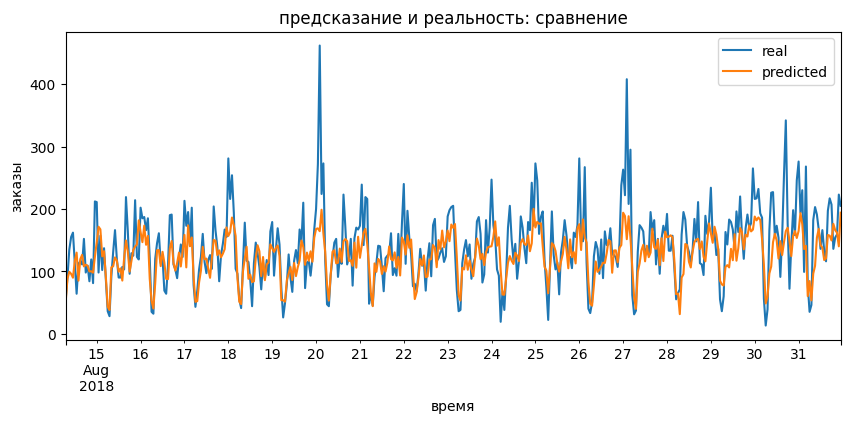

In [92]:
predicted = pd.Series(pred_test, index=y_test.index)

plt.figure(figsize=(10, 4))
y_test.plot(label='real', title='предсказание и реальность: сравнение')
predicted.plot(label='predicted')
plt.legend()
plt.xlabel("время")
plt.ylabel('заказы')
plt.show()

## Выводы

Мы обучили и проверили модель машинного обучения которая предсказывает количество заказов такси в следующий час. Значение метрики rmse не превышает 48. В ходе работы мы:

* провели ресемплирование заказов по одному часу
* изучили данные, обнаружили сезонность
* создали дополнительные признаки (час в дне, день в неделе, день в месяце, месяц в году, значения прошлых 168 часов)
* обучили модели с разными гиперпараметрами
* проверили лучшую модель на тестовой выборке(размер тестовой выборки 10% от общих данных)

Все модели показали достаточно близкие результаты. Самую большую рост эффективности для предсказаний мы получили не подбором моделей и их гиперпараметров, а ручным созданием признаков. Если нам важна интерпретируемось то мы можем слегка пожертвовать качеством у пользу интерпретируемости, например выбрав модель решающего дерева или линейной регрессии которые показали неплохие результаты.

Наилучшие результаты мы получили с помощью модели CatBoost, проверили на тестовой выборке что
* результат соотествует заданию, rmse 44.98 на тестовой выборке для CatBoostRegressor(loss_function="RMSE", iterations=250, depth=3), Learning rate 0.149255
* модель прошла проверку на адекватность
* графики ихсодного и предсказанного рядов довольно похожи
